In [1]:
import numpy as np
import matplotlib.pyplot as plt
import VBBinaryLensing
from scipy.optimize import minimize, fmin

import os
import torch
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
best_parameters = np.load('/work/hmzhao/best_parameters_gap.npy')

In [4]:
order = np.argsort(best_parameters[:, :, 0], axis=-1)
best_parameters_sort = best_parameters[np.arange(len(order))[:, None], order]
pred_chi2 = best_parameters_sort[:, 0, 2:]
order_close = np.argsort(((best_parameters[:, :, 2:] - Y[:4096*4, None, :-1].numpy())**2).sum(-1), axis=-1)
best_parameters_sort_close = best_parameters[np.arange(len(order))[:, None], order_close]
pred_close = best_parameters_sort_close[:, 0, 2:]

In [8]:
np.sum(pred_chi2[:, 0] == pred_close[:, 0]) / len(pred_chi2)

0.55731201171875

In [18]:
print('minimum chi2', np.bincount(order[:, 0]) / len(order))
print('minimum rmse', np.bincount(order_close[:, 0]) / len(order_close))

minimum chi2 [0.44610596 0.24694824 0.17254639 0.13439941]
minimum rmse [0.53643799 0.23358154 0.14465332 0.08532715]


In [19]:
def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

def compute_model_lc(time_array, fitting_parameters, VBBL):
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te, rho = 0, 1, 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False):
    magnifications = compute_model_lc(time, fitting_parameters, VBBL)
    chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
    if return_model:
        return chi2, fs, fb
    return chi2

def prepare_lc(X):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    return lc.numpy()

In [20]:
lc = prepare_lc(X)

In [21]:
def append_lgfs(lc, pred, verbose=True):
    lgfs = np.zeros((len(pred), 1))
    for i in tqdm(range(len(pred))):
        chi2, fs, fb = compute_chisq(pred[i, :4], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
        if fs / (fs + fb) < 0:
            if verbose:
                print(f'fs/fb < 0: {fs} {fb} {pred[i]} {chi2} {Y[i]}')
            lgfs[i] = 0
        else:
            lgfs[i] = np.log10(fs / (fs + fb))
    return np.hstack((pred, lgfs))
pred_chi2 = append_lgfs(lc, pred_chi2)

  0%|          | 0/16384 [00:00<?, ?it/s]

fs/fb < 0: 59.83040485566744 -61.613566363826976 [ 0.22739051 -0.11925451  0.65089521  1.22516041] 15096.68078997819 tensor([ 0.3244, -0.7293,  0.3530,  1.9074, -0.0133], dtype=torch.float64)


In [31]:
def plot_params(num, Y, pred, chi2, cal_mad=False,
                title=None, figsize=(12, 8), labelsize=14, alpha=0.1, save=None, show=True,
                correct=False,
                rmse_plot=False, rmse_list=None):
    pred = pred.copy()
    Y = Y.clone()
    if correct:
        for i in range(len(pred)):
            if pred[i, 1] > 0:
                pred[i, 1] = -pred[i, 1]
                pred[i, 3] = pred[i, 3] + 1
            if pred[i, 3] < 0:
                pred[i, 3] = - pred[i, 3]
            if pred[i, 3] > 2:
                pred[i, 3] = pred[i, 3] - 2

    valid = []
    ind_valid = np.ones((len(pred)))
    for i, (left, right) in enumerate([[0, 1], [-3, 0], [np.log10(0.3), np.log10(3)], [0, 2], [-1, 0]]):
        valid.append(np.sum(np.logical_and(pred[:, i] > left, pred[:, i] < right)) / len(pred))
        ind_valid = np.logical_and(ind_valid, np.logical_and(pred[:, i] > left, pred[:, i] < right))
    pred = pred[ind_valid]
    Y = Y[ind_valid]
    chi2 = chi2[ind_valid]
    
    rmse = []
    if cal_mad:
        mad = []

    ind_chi2 = []
    # chi2_list = [(0, 500), (500, 1000), (1000, 2000), (2000, np.inf)]
    chi2_list = [(2000, np.inf), (1000, 2000), (500, 1000), (0, 500)]
    colors = ['lightgrey', 'darkgrey', 'grey', 'black']
    # colors = ['black', 'grey', 'darkgrey', 'lightgrey']
    for left, right in chi2_list:
        ind_chi2.append(np.logical_and(chi2 > left, chi2 < right))

    fig = plt.figure(figsize=figsize)
    axq = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=1)
    axq.axis('square')
    axq.set_xlim(-3, 0)
    axq.set_ylim(-3, 0)
    axq.set_xlabel(r'true $\lg q$', fontsize=labelsize)
    axq.set_ylabel(r'predicted $\lg q$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axq.scatter(Y[:num, 1][ind], pred[:num, 1][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axq.plot(np.linspace(-3, 0), np.linspace(-3, 0), color='b', linestyle='dashed')
    # axq.legend(loc='lower right', prop={'size': 7})
    rmse.append(np.sqrt(torch.mean((Y[:num, 1] -  pred[:num, 1])**2).detach().cpu().item()))
    mad.append(torch.median(torch.abs(Y[:num, 1] -  pred[:num, 1])).detach().cpu().item())
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'MAD=%.4f' '\n' 'Valid=%.3f' % (rmse[-1], mad[-1], valid[1]), prop=dict(size=12), frameon=False, loc='upper left')
    axq.add_artist(at)
    
    axs = plt.subplot2grid(shape=(2, 3), loc=(0, 1), rowspan=1, colspan=1)
    axs.axis('square')
    axs.set_xlim(np.log10(0.3), np.log10(3))
    axs.set_ylim(np.log10(0.3), np.log10(3))
    axs.set_xlabel(r'true $\lg s$', fontsize=labelsize)
    axs.set_ylabel(r'predicted $\lg s$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axs.scatter(Y[:num, 2][ind], pred[:num, 2][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axs.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    # axs.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 2] -  pred[:num, 2])**2).detach().cpu().item()))
    mad.append(torch.median(torch.abs(Y[:num, 2] -  pred[:num, 2])).detach().cpu().item())
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'MAD=%.4f' '\n' 'Valid=%.3f' % (rmse[-1], mad[-1], valid[2]), prop=dict(size=12), frameon=False, loc='upper left')
    axs.add_artist(at)

    axu = plt.subplot2grid(shape=(2, 3), loc=(0, 2), rowspan=1, colspan=1)
    axu.axis('square')
    axu.set_xlim(0, 1)
    axu.set_ylim(0, 1)
    axu.set_xlabel(r'true $u_0$', fontsize=labelsize)
    axu.set_ylabel(r'predicted $u_0$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axu.scatter(Y[:num, 0][ind], pred[:num, 0][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axu.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    # axu.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 0] -  pred[:num, 0])**2).detach().cpu().item()))
    mad.append(torch.median(torch.abs(Y[:num, 0] -  pred[:num, 0])).detach().cpu().item())
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'MAD=%.4f' '\n' 'Valid=%.3f' % (rmse[-1], mad[-1], valid[0]), prop=dict(size=12), frameon=False, loc='upper left')
    axu.add_artist(at)

    axa = plt.subplot2grid(shape=(2, 3), loc=(1, 0), rowspan=1, colspan=1)
    axa.axis('square')
    axa.set_xlim(0, 360)
    axa.set_ylim(0, 360)
    axa.set_xlabel(r'true $\alpha$ (deg)', fontsize=labelsize)
    axa.set_ylabel(r'predicted $\alpha$ (deg)', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axa.scatter(Y[:num, 3][ind]*180, pred[:num, 3][ind]*180, s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axa.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    # axa.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 3] -  pred[:num, 3])**2).detach().cpu().item())*180)
    mad.append(torch.median(torch.abs(Y[:num, 3] -  pred[:num, 3])).detach().cpu().item()*180)
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'MAD=%.4f' '\n' 'Valid=%.3f' % (rmse[-1], mad[-1], valid[3]), prop=dict(size=12), frameon=False, loc='upper left')
    axa.add_artist(at)

    axf = plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=1)
    axf.axis('square')
    axf.set_xlim(-1, 0)
    axf.set_ylim(-1, 0)
    axf.set_xlabel(r'true $\lg f_s$', fontsize=labelsize)
    axf.set_ylabel(r'predicted $\lg f_s$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axf.scatter(Y[:num, 4][ind], pred[:num, 4][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axf.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
    rmse.append(np.sqrt((torch.mean((Y[:num, 4] -  pred[:num, 4])**2).detach().cpu().item())))
    mad.append(torch.median(torch.abs(Y[:num, 4] -  pred[:num, 4])).detach().cpu().item())
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'MAD=%.4f' '\n' 'Valid=%.3f' % (rmse[-1], mad[-1], valid[4]), prop=dict(size=12), frameon=False, loc='upper left')
    axf.add_artist(at)

    if rmse_plot:
        rmse_sub = np.array(rmse_list)[:, [1, 2, 0, 3, 4]].T

        ax_rmse = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1, colspan=1)
        ax_rmse.axis('square')
        ax_rmse.set_xlim(-0.2/1.5*0.4, 1.3/1.5*0.4)
        ax_rmse.set_ylim(-0.05, 0.35)
        labels = [r'$\lg q$', r'$\lg s$', r'$u_0$', r'$\alpha$', r'$\lg f_s$']
        cats = ['500', '400', '200', '100']
        # markers = ['o', 's', '^', '+', 'x']
        rmses = np.log10(rmse_sub / rmse_sub[:, [0]])
        left = 1; right = None
        for i, label in enumerate(labels):
            plt.plot((np.arange(len(cats[left:right])))/(len(cats[left:right])-1)/1.5*0.4, rmses[i, left:right], label=label)
            plt.scatter((np.arange(len(cats[left:right])))/(len(cats[left:right])-1)/1.5*0.4, rmses[i, left:right])
        plt.ylabel(r'$\lg$ (RMSE / RMSE_500)', fontsize=14)
        plt.xlabel('Number of points', fontsize=14)
        plt.xticks(np.arange(len(cats[left:right]))/(len(cats[left:right])-1)/1.5*0.4, cats[left:right], fontsize=14)
        plt.legend()

    plt.tight_layout()
        
    if title != None:
        fig.suptitle(title)

    if save != None:
        plt.savefig(save)
    
    if show:
        plt.show()
    else:
        plt.close()
    
    if cal_mad:
        return rmse, mad
    return rmse

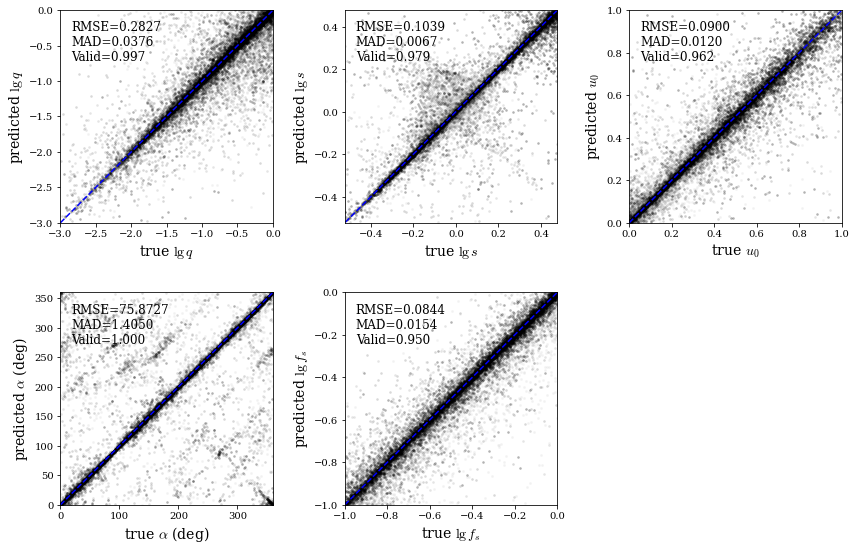

In [32]:
rmse_gap_chi2, mad_chi2 = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_chi2, cal_mad=True, chi2=best_parameters_sort[:, 0, 0], alpha=0.2, correct=True, show=True)

  0%|          | 0/16384 [00:00<?, ?it/s]

fs/fb < 0: -0.12154480426299585 1.2539151041129628 [ 0.77372701 -0.09380024  0.56135992  1.74380525] 1006.4685384624361 tensor([ 0.1051, -0.2071,  0.4696,  1.8546, -0.4434], dtype=torch.float64)
fs/fb < 0: -0.16863297284577072 1.7840568464606292 [0.03061243 0.01295198 0.38789592 0.49933596] 56177.09616401374 tensor([ 0.0377, -0.0058,  0.4003,  0.0015, -0.2529], dtype=torch.float64)


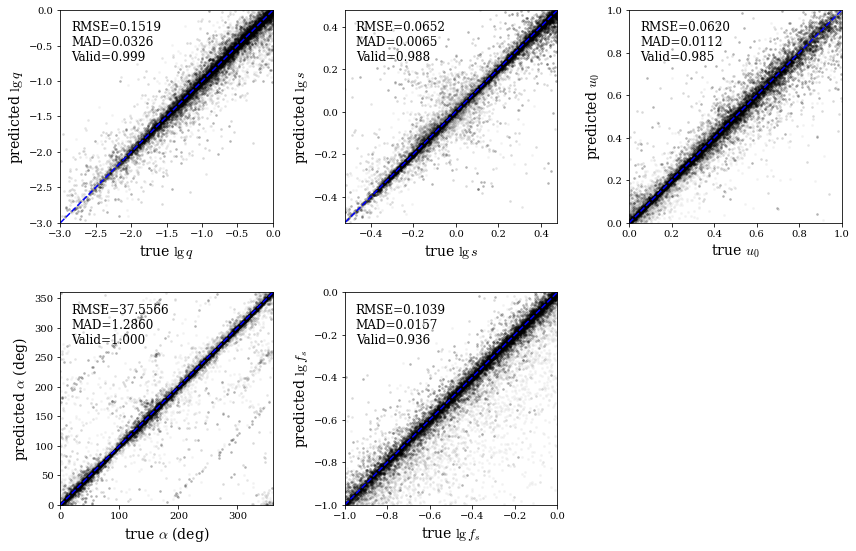

In [30]:
pred_close = append_lgfs(lc, pred_close)
rmse_gap_close, mad_close = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_close, cal_mad=True, chi2=best_parameters_sort_close[:, 0, 0], alpha=0.2, correct=True, show=True)

In [ ]:
rmse_list_chi2 = []
rmse_list_close = []
for name in tqdm(['', '_400', '_200', '_100']):
    best_parameters = np.load(f'/work/hmzhao/best_parameters{name}.npy')
    order = np.argsort(best_parameters[:, :, 0], axis=-1)
    best_parameters_sort = best_parameters[np.arange(len(order))[:, None], order]
    pred_chi2 = best_parameters_sort[:, 0, 2:]
    order_close = np.argsort(((best_parameters[:, :, 2:] - Y[:4096*4, None, :-1].numpy())**2).sum(-1), axis=-1)
    best_parameters_sort_close = best_parameters[np.arange(len(order))[:, None], order_close]
    pred_close = best_parameters_sort_close[:, 0, 2:]
    pred_chi2 = append_lgfs(lc, pred_chi2, verbose=False)
    pred_close = append_lgfs(lc, pred_close, verbose=False)
    rmse_list_chi2.append(plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_chi2, cal_mad=True, chi2=best_parameters_sort[:, 0, 0], alpha=0.2, correct=True, show=False))
    rmse_list_close.append(plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_close, cal_mad=True, chi2=best_parameters_sort_close[:, 0, 0], alpha=0.2, correct=True, show=False))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [176]:
np.savez('/work/hmzhao/rmse_list_chi2_close.npz', rmse_list_chi2=rmse_list_chi2, rmse_list_close=rmse_list_close)

In [33]:
rmse_list_chi2_close = np.load('/work/hmzhao/rmse_list_chi2_close.npz')
rmse_list_chi2 = rmse_list_chi2_close['rmse_list_chi2']
rmse_list_close = rmse_list_chi2_close['rmse_list_close']

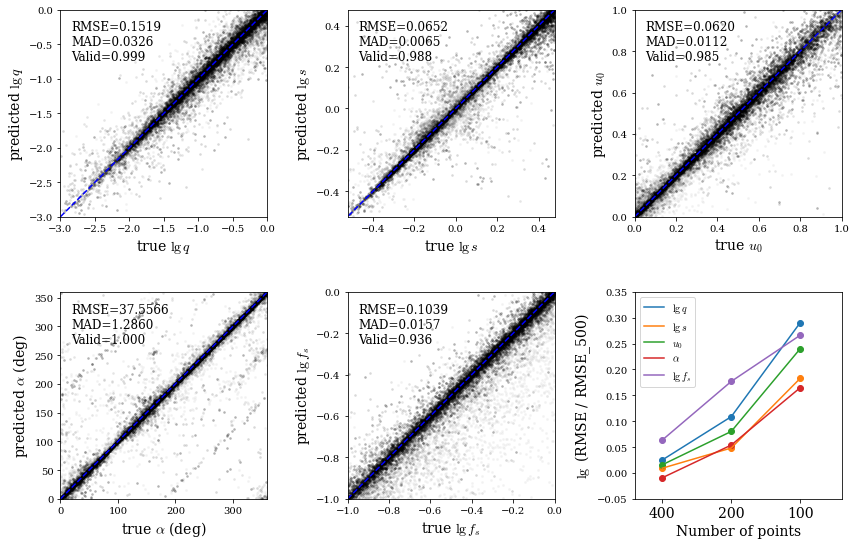

In [34]:
rmse_gap_close = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_close, cal_mad=True, chi2=best_parameters_sort_close[:, 0, 0], alpha=0.2, correct=True, show=True,
                            rmse_plot=True, rmse_list=rmse_list_close, save='opt_close.pdf')

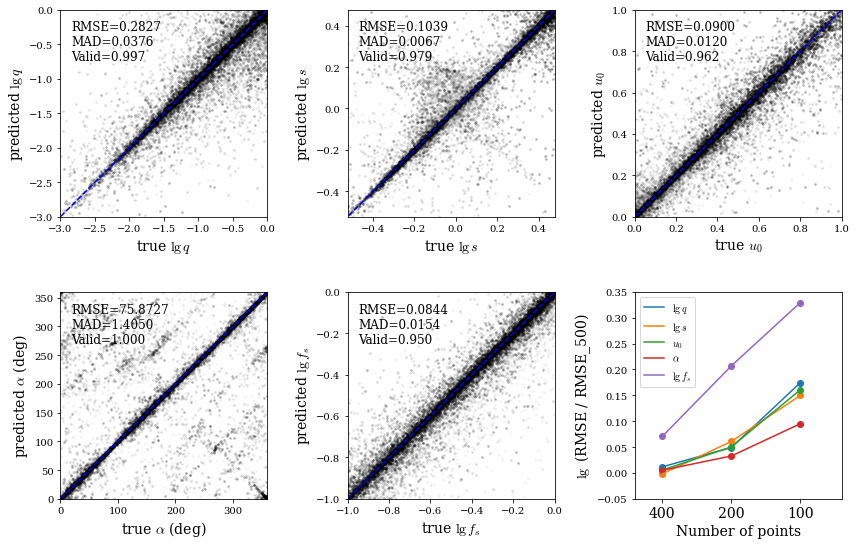

In [35]:
rmse_gap_chi2 = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_chi2, cal_mad=True, chi2=best_parameters_sort[:, 0, 0], alpha=0.2, correct=True, show=True,
                            rmse_plot=True, rmse_list=rmse_list_chi2, save='opt_chi2.pdf')

In [37]:
def ecdf(x):
    xnew = np.sort(x)
    xval, cdf = [], []
    for i in range(len(xnew)):
        cdf.append(i)
        xval.append(xnew[i])
        cdf.append(i+1)
        xval.append(xnew[i])
    cdf = np.array(cdf)/cdf[-1]
    xval = np.array(xval)
    return xval, cdf

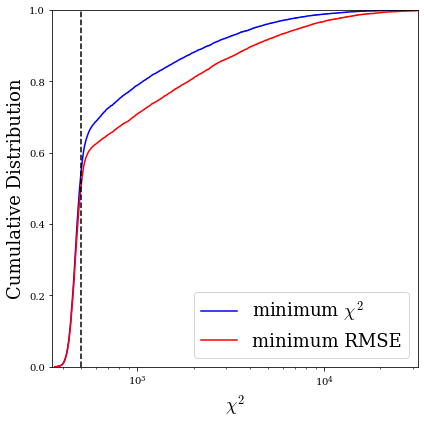

In [53]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
# plt.hist(best_parameters_sort[:, 0, 0], bins=100, density=True, cumulative=True, histtype='step', color='blue')
# plt.hist(best_parameters_sort_close[:, 0, 0], bins=100, density=True, cumulative=True, histtype='step', color='red')
plt.plot(*ecdf(best_parameters_sort[:, 0, 0]), label=r'minimum $\chi^2$', color='blue')
plt.plot(*ecdf(best_parameters_sort_close[:, 0, 0]), label=r'minimum RMSE', color='red')
plt.xscale('log')
plt.xlabel(r'$\chi^2$', fontsize=18)
plt.ylabel(r'Cumulative Distribution', fontsize=18)
plt.xlim(350, 10**4.5)
plt.ylim(0, 1)
plt.legend(fontsize=18, loc='lower right')
plt.vlines(500, 0, 1, linestyles='dashed', color='black')

plt.tight_layout()
plt.savefig('./cdf_chi2.pdf')
plt.show()

In [30]:
best_parameters_sort[:, 0, 0].mean(), best_parameters_sort_close[:, 0, 0].mean()

(1159.0194209722165, 1749.8898471290292)

In [31]:
np.median(best_parameters_sort[:, 0, 0]), np.median(best_parameters_sort_close[:, 0, 0])

(491.451635902515, 499.24358639127433)